In [1017]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

In [1018]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/data/train.csv'
test_path  = '/data/ephemeral/home/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [1019]:
dt_test.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0
2,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,202307,28,15,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0
3,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,202308,10,14,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0
4,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,104.4300,202308,18,6,1984,...,위탁,61064.24,419.0,의무,1984-12-22 00:00:00.0,Y,N,127.055990,37.483894,2013-03-07 09:46:28.0


In [1020]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [1021]:
dt.drop(columns=['아파트명', '번지', '본번', '부번', '계약일', '도로명', '중개사소재지', 'k-전화번호','k-팩스번호',
                 '단지소개기존clob','k-전체동수','k-전체세대수','k-건설사(시공사)',
                 'k-시행사','k-연면적','k-주거전용면적','k-관리비부과면적','k-홈페이지','k-등록일자','k-수정일자',
                 '고용보험관리번호','건축면적','주차대수','단지승인일','사용허가여부','관리비 업로드','단지신청일'], inplace=True)

In [1022]:
dt.drop(columns = ['좌표X', '좌표Y'], inplace=True)

In [1023]:
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '해제사유발생일', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target'],
      dtype='object')

In [1024]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt.columns:
    if pd.api.types.is_numeric_dtype(dt[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', '해제사유발생일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'target']
범주형 변수: ['시군구', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4']


# 결측치 처리


### 결측치가 있는 열 중 일부 제거


In [1025]:
dt.isnull().sum().sort_values(ascending=False)

k-135㎡초과                  1118495
해제사유발생일                   1112839
세대전기계약방법                   878747
청소비관리형태                    871178
경비비관리형태                    870988
k-단지분류(아파트,주상복합등등)         870691
k-복도유형                     869890
k-사용검사일-사용승인일              869696
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-전용면적별세대현황(60㎡이하)         869608
기타/의무/임대/임의=1/2/3/4        869563
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-난방방식                     869563
시군구                             0
전용면적(㎡)                         0
거래유형                            0
등기신청일자                          0
건축년도                            0
층                               0
계약년월                            0
target                          0
dtype: int64

In [1026]:
dt.drop(columns=['해제사유발생일'], inplace=True)
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target'],
      dtype='object')

In [1027]:
dt.shape

(1118822, 22)

### 결측치가 있는 행 제거


In [1028]:
missing_count = dt.isnull().sum(axis=1)
print(max(missing_count))

14


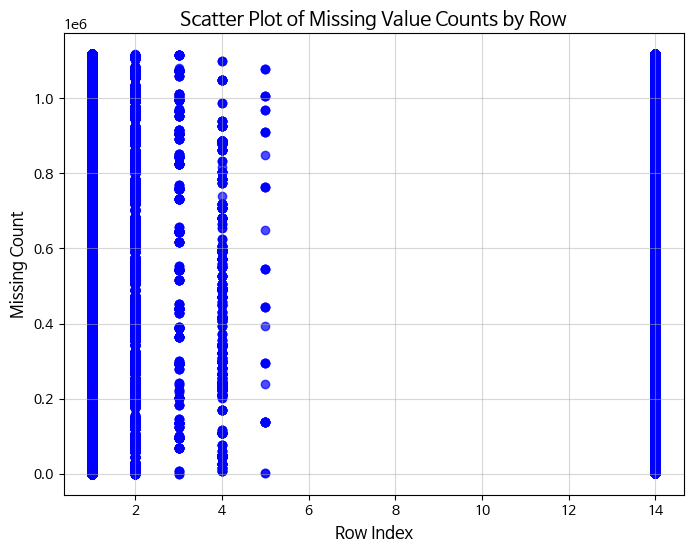

In [1029]:
plt.figure(figsize=(8, 6))
plt.scatter(missing_count, range(len(missing_count)), color='blue', alpha=0.7)
plt.title('Scatter Plot of Missing Value Counts by Row', fontsize=14)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('Missing Count', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

In [1030]:
threshold = 15  # 결측치 개수

# 각 행에 대해 결측치 개수를 계산하고, threshold 이상의 결측치를 가진 행을 삭제
dt = dt[dt.isnull().sum(axis=1) < threshold]
dt.shape

(1118822, 22)

In [1031]:
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target'],
      dtype='object')

# 이상치 처리
ㄴ 추후 예정

# 데이터 변환

In [1032]:
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target'],
      dtype='object')

### split 시군구


In [1033]:
split_df = dt['시군구'].str.split(' ', expand=True)
split_df.columns = ['시', '구', '동'] 
split_df.drop(columns='시', inplace=True)
split_df.sample(20)

,구,동
564373,관악구,봉천동
345308,동작구,사당동
1045345,동대문구,장안동
993371,성동구,옥수동
783438,구로구,고척동
433133,양천구,신월동
1003650,은평구,진관동
245998,강서구,등촌동
681680,구로구,온수동
330096,노원구,월계동


In [1034]:
dt.drop(columns='시군구', inplace=True)
dt = pd.concat([dt, split_df], axis=1)
dt.columns

Index(['전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동'],
      dtype='object')

전용면적(㎡) : MinMax Scaling

계약년월 :연도, 월 분리 /  월 -> 성수기(6~8월 제외), 비수기(6~8월)로 구분

층 : Min max scaling

건축년도 : 2024년을 기준으로 차이값을 계산 후 이를 역수로 치환 (음수로 사용해볼수도 있음)

등기신청일자 : 있으면 1 없으면 0

거래유형 : (중개거래1, 직거래0)

## 계약년월 -> 연, 월 분할 / 월 -> 성수기 여부로 변환

In [1035]:
dt['계약년도'] = dt['계약년월'].astype(str).str[:4].astype(int)
dt['계약월'] = dt['계약년월'].astype(str).str[4:6].astype(int)
dt.drop(columns=['계약년월'], inplace=True)
dt['성수기여부'] = dt['계약월'].apply(lambda x: 1 if 6 <= x <= 8 else 0) # 성수기 = 1, 비성수기 = 0
dt.drop(columns='계약월', inplace=True)
dt.columns

# maps = {'비성수기' : 0, '성수기' : 1}
# dt['성수기여부'] = dt['성수기여부'].map(maps)

Index(['전용면적(㎡)', '층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동', '계약년도', '성수기여부'],
      dtype='object')

## 전용면적, 층 MinMaxScaler()


In [1036]:
scaler = MinMaxScaler()
dt['전용면적'] = scaler.fit_transform(dt[['전용면적(㎡)']])
scaler = MinMaxScaler()
dt['층'] = scaler.fit_transform(dt[['층']])
dt.drop(columns=['전용면적(㎡)'], inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적'],
      dtype='object')

In [1037]:
dt.sample(5)

,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-사용검사일-사용승인일,...,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,동,계약년도,성수기여부,전용면적
493198,0.315068,1993,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,82000,동작구,대방동,2017,0,0.299855
970695,0.205479,1983,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,168500,강남구,압구정동,2010,0,0.230002
623522,0.109589,2008,,-,아파트,분양,위탁관리,계단식,지역난방,2008-09-30 00:00:00.0,...,위탁,종합계약,위탁,의무,81500,송파구,잠실동,2015,0,0.120541
39507,0.219178,1987,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,30450,도봉구,도봉동,2018,1,0.157639
929814,0.232877,2005,,-,아파트,분양,위탁관리,계단식,개별난방,2005-05-23 00:00:00.0,...,위탁,단일계약,직영,의무,38000,노원구,월계동,2011,1,0.180603


In [1038]:
dt.isnull().sum()

층                               0
건축년도                            0
등기신청일자                          0
거래유형                            0
k-단지분류(아파트,주상복합등등)         870691
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-사용검사일-사용승인일              869696
k-전용면적별세대현황(60㎡이하)         869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-135㎡초과                  1118495
경비비관리형태                    870988
세대전기계약방법                   878747
청소비관리형태                    871178
기타/의무/임대/임의=1/2/3/4        869563
target                          0
구                               0
동                               0
계약년도                            0
성수기여부                           0
전용면적                            0
dtype: int64

## 건축년도 : 1 / 2024 - 건축년도


In [1039]:
# 4. 건축년도 : 2024년 기준 차이값 계산 후 역수
dt['건축년도'] = 2024 - dt['건축년도']
dt['건축년도'] = (1 / dt['건축년도']).round(2)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적'],
      dtype='object')

## 중간점검


In [1040]:
dt[['계약년도', '성수기여부', '전용면적', '층','건축년도']].sample(5)

,계약년도,성수기여부,전용면적,층,건축년도
754581,2015,0,0.086628,0.123288,0.11
213422,2017,0,0.179846,0.178082,0.05
723026,2015,0,0.180908,0.136986,0.04
208537,2023,0,0.167101,0.123288,0.03
682874,2015,1,0.180908,0.164384,0.05


In [1041]:
dt[['계약년도', '성수기여부', '전용면적', '층','건축년도']].isnull().sum()

계약년도     0
성수기여부    0
전용면적     0
층        0
건축년도     0
dtype: int64

## 등기신청일자

등기신청일자 : 있으면 1 없으면 0

In [1042]:
dt[dt['등기신청일자'] == ' ' ]

,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-사용검사일-사용승인일,...,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,동,계약년도,성수기여부,전용면적
0,0.095890,0.03,,-,아파트,분양,자치관리,계단식,개별난방,1987-11-21 00:00:00.0,...,직영,단일계약,직영,임의,124000,강남구,개포동,2017,0,0.168839
1,0.109589,0.03,,-,아파트,분양,자치관리,계단식,개별난방,1987-11-21 00:00:00.0,...,직영,단일계약,직영,임의,123500,강남구,개포동,2017,0,0.168839
2,0.123288,0.03,,-,아파트,분양,자치관리,계단식,개별난방,1987-11-21 00:00:00.0,...,직영,단일계약,직영,임의,91500,강남구,개포동,2017,0,0.108520
3,0.109589,0.03,,-,아파트,분양,자치관리,계단식,개별난방,1987-11-21 00:00:00.0,...,직영,단일계약,직영,임의,130000,강남구,개포동,2018,0,0.168839
4,0.082192,0.03,,-,아파트,분양,자치관리,계단식,개별난방,1987-11-21 00:00:00.0,...,직영,단일계약,직영,임의,117000,강남구,개포동,2018,0,0.168839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0.205479,0.04,,-,아파트,분양,위탁관리,혼합식,개별난방,1998-11-28 00:00:00.0,...,위탁,종합계약,위탁,의무,20000,은평구,구산동,2007,1,0.120492
1118818,0.191781,0.04,,-,아파트,분양,위탁관리,혼합식,개별난방,1998-11-28 00:00:00.0,...,위탁,종합계약,위탁,의무,20000,은평구,구산동,2007,1,0.120492
1118819,0.328767,0.04,,-,아파트,분양,위탁관리,혼합식,개별난방,1998-11-28 00:00:00.0,...,위탁,종합계약,위탁,의무,28000,은평구,구산동,2007,1,0.180570
1118820,0.164384,0.04,,-,아파트,분양,위탁관리,혼합식,개별난방,1998-11-28 00:00:00.0,...,위탁,종합계약,위탁,의무,29000,은평구,구산동,2007,0,0.180570


In [1043]:
dt['등기신청일자'] = dt['등기신청일자'].apply(lambda x:0.1 if x == ' ' else 1)
dt['등기신청일자'].unique()

array([0.1, 1. ])

## 거래유형

In [1044]:
dt['거래유형'].unique()

array(['-', '중개거래', '직거래'], dtype=object)

In [1045]:
dt['거래유형'] = dt['거래유형'].apply(lambda x : 0.1 if x == '직거래' else(1 if x == '중개거래' else 0.5))

In [1046]:
dt['거래유형'].unique()

array([0.5, 1. , 0.1])

In [1047]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적'],
      dtype='object')

##
k-단지분류(아파트,주상복합등등) : 아파트 > 주상복합 ? 연립주택 > 도시형생활 주택(주상복합 > 아파트) 내림차순 번호 할당

k-세대타입(분양형태) : O : 분양, (기타 )> 임대

k-관리방식 : O : 위탁관리 > 자치관리 > 직영

k-복도유형 : O : 계단식 > 혼합식 > 복도식 > 타워형 > 기타

k-난방방식 : O :개별난방 > 지역난방 > 중앙난방 > 기타

k-사용검사일-사용승인일 : - : 사용승인일 - 사용검사일 의 결과값에 대해서 Min Max Scale

## 단지분류 : 아파트 > 주상복합 ? 연립주택 > 도시형생활 주택(주상복합 > 아파트) 내림차순 번호 할당

In [1048]:
dt['k-단지분류(아파트,주상복합등등)'].unique()

array(['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)'],
      dtype=object)

In [1049]:
maps = {
    '아파트' : 5,
    '주상복합' : 4,
    '연립주택택' : 3,
    '도시형 생활주택(주상복합)' : 2,
    '도시형 생활주택(아파트)' : 1, 
}
dt['단지분류'] = dt['k-단지분류(아파트,주상복합등등)'].map(maps)
# dt['단지분류'].apply(lambda x: 0 if x == pd.isna(x) else x)
dt['단지분류'].fillna(0, inplace = True)
dt.drop(columns='k-단지분류(아파트,주상복합등등)', inplace = True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '단지분류'],
      dtype='object')

## 세대타입(분양형태) : 분양, (기타 )> 임대 = 1, 0.5, 0.1


In [1050]:
dt['k-세대타입(분양형태)'].unique()

array(['분양', '기타', nan, '임대'], dtype=object)

In [1051]:
maps = {
    '분양' : 1,
    '기타' : 0.5,
    '임대' : 0.1
}
dt['세대타입(분양형태)'] = dt['k-세대타입(분양형태)'].map(maps)
dt.drop(columns='k-세대타입(분양형태)' ,inplace=True)
dt['세대타입(분양형태)'].fillna(0.1, inplace=True)
dt['세대타입(분양형태)'].unique()

array([1. , 0.5, 0.1])

In [1052]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '단지분류', '세대타입(분양형태)'],
      dtype='object')

## 관리방식 : 위탁관리 > 자치관리 > 직영 (1, 0.5, 0.1)


In [1053]:
dt['k-관리방식'].unique()

array(['자치관리', '위탁관리', '직영', nan], dtype=object)

In [1054]:
maps = {
    '위탁관리' : 1,
    '자치관리' : 0.5,
    '직영' : 0.1
}
dt['관리방식'] = dt['k-관리방식'].map(maps)
dt.drop(columns='k-관리방식' ,inplace=True)
dt['관리방식'].fillna(0.1, inplace = True)
dt['관리방식'].unique()

array([0.5, 1. , 0.1])

## 복도유형 : 계단식 > 혼합식 > 복도식 > 타워형 > 기타 (4, 3, 2, 1, 0.1)


In [1055]:
dt['k-복도유형'].unique()

array(['계단식', '혼합식', '복도식', '타워형', '기타', nan], dtype=object)

In [1056]:
maps = {
    '계단식' : 4,
    '혼합식' : 3,
    '복도식' : 2,
    '타워형' : 1,
    '기타' : 0.1
}
dt['복도유형'] = dt['k-복도유형'].map(maps)
dt.drop(columns= 'k-복도유형',inplace=True)
dt['복도유형'].fillna(0.1, inplace=True)
dt['복도유형'].unique()

array([4. , 3. , 2. , 1. , 0.1])

In [1057]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-난방방식', 'k-사용검사일-사용승인일',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동', '계약년도', '성수기여부', '전용면적', '단지분류', '세대타입(분양형태)',
       '관리방식', '복도유형'],
      dtype='object')

## 난방방식 : 개별난방 > 지역난방 > 중앙난방 > 기타 (3, 2, 1, 0.1)


In [1058]:
dt['k-난방방식'].unique()

array(['개별난방', '지역난방', '기타', nan, '중앙난방'], dtype=object)

In [1059]:
maps = {
    '개별난방' : 3,
    '지역난방' : 2,
    '중앙난방' : 1,
    '기타' : 0.1
}
dt['난방방식'] = dt['k-난방방식'].map(maps)
dt.drop(columns= 'k-난방방식',inplace=True)
dt['난방방식'].fillna(0.1, inplace=True)
dt['난방방식'].unique()

array([3. , 2. , 0.1, 1. ])

In [1060]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-사용검사일-사용승인일', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '단지분류', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식'],
      dtype='object')

## 사용검사일-사용승인일 : 제거


In [1061]:
tmp = dt['k-사용검사일-사용승인일'].str.split(' ', expand=True)
tmp.columns = ['Date', 'Time'] 
tmp['Time'].value_counts()

00:00:00.0    249126
Name: Time, dtype: int64

In [1062]:
dt.drop(columns='k-사용검사일-사용승인일', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '단지분류', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식'],
      dtype='object')

## 면적별~


In [1063]:
dt[['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하','k-135㎡초과']].isnull().sum()

k-전용면적별세대현황(60㎡이하)         869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-85㎡~135㎡이하               869608
k-135㎡초과                  1118495
dtype: int64

In [1064]:
dt['전용면적별세대현황(60㎡이하)'] = dt['k-전용면적별세대현황(60㎡이하)'].fillna(dt['k-전용면적별세대현황(60㎡이하)'].mean())
dt['전용면적별세대현황(60㎡~85㎡이하)'] = dt['k-전용면적별세대현황(60㎡~85㎡이하)'].fillna(dt['k-전용면적별세대현황(60㎡~85㎡이하)'].mean())
dt['85㎡~135㎡이하'] = dt['k-85㎡~135㎡이하'].fillna(dt['k-85㎡~135㎡이하'].mean())
dt['135㎡초과'] = dt['k-135㎡초과'].fillna(dt['k-135㎡초과'].mean())
dt.drop(columns=['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하','k-135㎡초과'], inplace = True)
dt[['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']].isnull().sum()

전용면적별세대현황(60㎡이하)        0
전용면적별세대현황(60㎡~85㎡이하)    0
85㎡~135㎡이하              0
135㎡초과                  0
dtype: int64

In [1065]:
categories = ['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']
for c in categories:
    scaler = MinMaxScaler()
    dt[c] = scaler.fit_transform(dt[[c]])

In [1066]:
dt[['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']].sample(10)

,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),85㎡~135㎡이하,135㎡초과
1098013,0.096063,0.092890,0.111686,0.0
362250,0.096063,0.092890,0.111686,0.0
414273,0.096063,0.092890,0.111686,0.0
85650,0.000000,0.008963,0.101333,0.0
698007,0.096063,0.092890,0.111686,0.0
185232,0.000000,0.079501,0.288000,0.0
800855,0.096063,0.092890,0.111686,0.0
429262,0.231156,0.787607,0.324000,0.0
1084403,0.096063,0.092890,0.111686,0.0
70848,0.096063,0.092890,0.111686,0.0


In [1067]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '단지분류', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과'],
      dtype='object')

## 중간점검

경비비관리형태 : 위탁 > 직영 > 위탁+직영 > 기타 : 내림차순 ~ 0

세대전기계약방법 : 종합계약 > 단일계약 : 1, 0

청소비관리형태 : 위탁 > 직영 > 위탁+직영 : 2, 1, 0

기타/의무/임대/임의=1/2/3/4 : 의무 > 기타 > 임의 > 임대


## 경비비관리형태 : 위탁 > 직영 > 위탁+직영 > 기타


In [1068]:
dt['경비비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [1069]:
maps = {
    '위탁' : 3,
    '직영' : 2,
    '위탁+직영' : 1,
    '기타' : 0.1
}
dt['경비비관리형태'] = dt['경비비관리형태'].map(maps)
dt['경비비관리형태'].fillna(0.1, inplace=True)
dt['경비비관리형태'].unique()

array([2. , 3. , 1. , 0.1])

## 세대전기계약방법 : 종합계약 > 단일계약 : 2, 1

In [1070]:
dt['세대전기계약방법'].unique()

array(['단일계약', '종합계약', nan], dtype=object)

In [1071]:
maps = {
    '종합계약' : 2,
    '단일계약' : 1,
}
dt['세대전기계약방법'] = dt['세대전기계약방법'].map(maps)
dt['세대전기계약방법'].fillna(0.5, inplace=True)
dt['세대전기계약방법'].unique()

array([1. , 2. , 0.5])

## 청소비관리형태 : 위탁 > 직영 > 위탁+직영 : 2, 1, 0

In [1072]:
dt['청소비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [1073]:
maps = {
    '위탁' : 3,
    '직영' : 2,
    '위탁+직영' : 1,
    '기타' : 0.1,
}
dt['청소비관리형태'] = dt['청소비관리형태'].map(maps)
dt['청소비관리형태'].fillna(0.1, inplace=True)
dt['청소비관리형태'].unique()

array([2. , 3. , 1. , 0.1])

## 기타/의무/임대/임의

In [1074]:
dt['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    239198
기타      4177
임의      3682
임대      2202
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

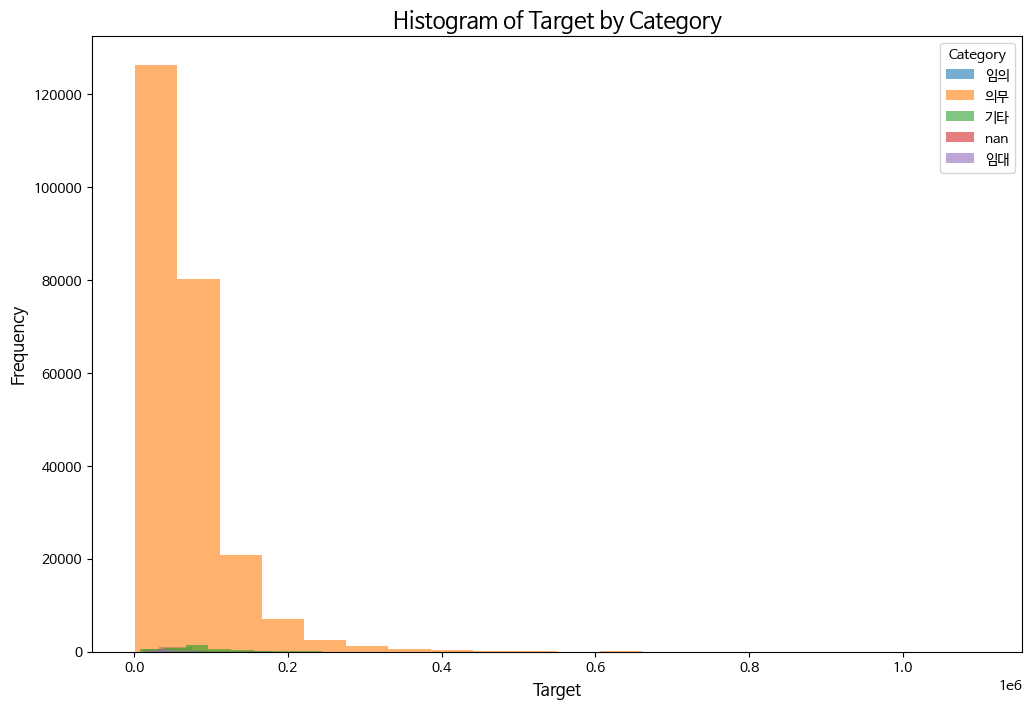

In [1075]:
categories = dt['기타/의무/임대/임의=1/2/3/4'].unique()

plt.figure(figsize=(12, 8))
for category in categories:
    subset = dt[dt['기타/의무/임대/임의=1/2/3/4'] == category]
    plt.hist(subset['target'], bins=20, alpha=0.6, label=category)

plt.title('Histogram of Target by Category', fontsize=16)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Category')
plt.show()

In [1076]:
maps = {
    '의무' : 3,
    '임의' : 1,
    '임대대' : 0.5,
    '기타' : 0.1,
}
dt['기타/의무/임대/임의=1/2/3/4'] = dt['기타/의무/임대/임의=1/2/3/4'].map(maps)
dt['기타/의무/임대/임의=1/2/3/4'].fillna(0.1, inplace=True)
dt['기타/의무/임대/임의=1/2/3/4'].unique()

array([1. , 3. , 0.1])

In [1077]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '단지분류', '세대타입(분양형태)', '관리방식', '복도유형', '난방방식', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과'],
      dtype='object')

## Endpoint


In [1078]:
# 세대타입, 관리방식, 난방방식방방식
dt.sample(5)

,층,건축년도,등기신청일자,거래유형,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,...,전용면적,단지분류,세대타입(분양형태),관리방식,복도유형,난방방식,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),85㎡~135㎡이하,135㎡초과
284170,0.136986,0.05,0.1,0.5,0.1,0.5,0.1,0.1,42000,양천구,...,0.173546,0.0,0.1,0.1,0.1,0.1,0.096063,0.09289,0.111686,0.0
145694,0.260274,0.05,0.1,0.5,0.1,0.5,0.1,0.1,17550,강동구,...,0.057181,0.0,0.1,0.1,0.1,0.1,0.096063,0.09289,0.111686,0.0
22994,0.219178,0.04,0.1,0.5,0.1,0.5,0.1,0.1,75000,광진구,...,0.120492,0.0,0.1,0.1,0.1,0.1,0.096063,0.09289,0.111686,0.0
400069,0.191781,0.04,0.1,0.5,0.1,0.5,0.1,0.1,50000,강서구,...,0.232585,0.0,0.1,0.1,0.1,0.1,0.096063,0.09289,0.111686,0.0
862068,0.383562,0.06,0.1,0.5,0.1,0.5,0.1,0.1,40500,구로구,...,0.180932,0.0,0.1,0.1,0.1,0.1,0.096063,0.09289,0.111686,0.0


## 구 컬럼 처리 

1. map 이용
2. 원핫인코딩(보류)

In [1079]:
len(dt['구'].unique())

25

In [1080]:
idx = dt.groupby('구')['target'].mean().sort_values(ascending=True).index
print(idx)

Index(['도봉구', '금천구', '노원구', '중랑구', '강북구', '구로구', '관악구', '은평구', '강서구', '성북구',
       '동대문구', '서대문구', '강동구', '영등포구', '종로구', '양천구', '동작구', '중구', '마포구', '광진구',
       '성동구', '송파구', '용산구', '서초구', '강남구'],
      dtype='object', name='구')


In [1081]:
maps = { idx[i-1] : i for i in range(1, len(idx) + 1) }
maps

{'도봉구': 1,
 '금천구': 2,
 '노원구': 3,
 '중랑구': 4,
 '강북구': 5,
 '구로구': 6,
 '관악구': 7,
 '은평구': 8,
 '강서구': 9,
 '성북구': 10,
 '동대문구': 11,
 '서대문구': 12,
 '강동구': 13,
 '영등포구': 14,
 '종로구': 15,
 '양천구': 16,
 '동작구': 17,
 '중구': 18,
 '마포구': 19,
 '광진구': 20,
 '성동구': 21,
 '송파구': 22,
 '용산구': 23,
 '서초구': 24,
 '강남구': 25}

In [1082]:
dt['구'] = dt['구'].map(maps)
dt['구'].unique()

array([25, 13,  5,  9,  7, 20,  6,  2,  3,  1, 11, 17, 19, 12, 24, 21, 10,
       22, 16, 14, 23,  8, 15, 18,  4])

In [1083]:
dt.head()

,층,건축년도,등기신청일자,거래유형,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,...,전용면적,단지분류,세대타입(분양형태),관리방식,복도유형,난방방식,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),85㎡~135㎡이하,135㎡초과
0,0.095890,0.03,0.1,0.5,2.0,1.0,2.0,1.0,124000,25,...,0.168839,5.0,1.0,0.5,4.0,3.0,0.00402,0.048714,0.0,0.0
1,0.109589,0.03,0.1,0.5,2.0,1.0,2.0,1.0,123500,25,...,0.168839,5.0,1.0,0.5,4.0,3.0,0.00402,0.048714,0.0,0.0
2,0.123288,0.03,0.1,0.5,2.0,1.0,2.0,1.0,91500,25,...,0.108520,5.0,1.0,0.5,4.0,3.0,0.00402,0.048714,0.0,0.0
3,0.109589,0.03,0.1,0.5,2.0,1.0,2.0,1.0,130000,25,...,0.168839,5.0,1.0,0.5,4.0,3.0,0.00402,0.048714,0.0,0.0
4,0.082192,0.03,0.1,0.5,2.0,1.0,2.0,1.0,117000,25,...,0.168839,5.0,1.0,0.5,4.0,3.0,0.00402,0.048714,0.0,0.0


In [1084]:
!pwd

/data/ephemeral/home/code


## 동 컬럼 처리 (일단은 drop)

In [1085]:
dt.drop(columns='동', inplace = True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '계약년도', '성수기여부', '전용면적', '단지분류',
       '세대타입(분양형태)', '관리방식', '복도유형', '난방방식', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과'],
      dtype='object')

In [1086]:
# idx = dt.groupby('동')['target'].mean().sort_values(ascending=True).index
# print(idx)
# maps = { idx[i-1] : i for i in range(1, len(idx) + 1) }
# maps
# dt['동'] = dt['동'].map(maps)
# dt['동'].unique()

# 파일저장

In [1088]:
dt.to_csv('./new_train.csv', index=False)

# EDA

In [ ]:
rows = dt.shape[0]
over70 = []
over80 = []
for col in dt.columns:
    nand = (dt[col].isnull().sum() / rows) * 100
    if nand >= 70:
        over70.append(col)
        print(f'{col}의 결측치 비율 {nand}%')
    if nand >= 80:
        over80.append(col)

해제사유발생일의 결측치 비율 99.46524111967766%
k-단지분류(아파트,주상복합등등)의 결측치 비율 77.8221200512682%
k-전화번호의 결측치 비율 77.78484870694355%
k-팩스번호의 결측치 비율 78.00543786232305%
단지소개기존clob의 결측치 비율 93.87015986457185%
k-세대타입(분양형태)의 결측치 비율 77.72129972417417%
k-관리방식의 결측치 비율 77.72129972417417%
k-복도유형의 결측치 비율 77.75052689346474%
k-난방방식의 결측치 비율 77.72129972417417%
k-전체동수의 결측치 비율 77.81666788818954%
k-전체세대수의 결측치 비율 77.72129972417417%
k-건설사(시공사)의 결측치 비율 77.85492240946282%
k-시행사의 결측치 비율 77.87244083509263%
k-사용검사일-사용승인일의 결측치 비율 77.73318722728013%
k-연면적의 결측치 비율 77.72129972417417%
k-주거전용면적의 결측치 비율 77.72532181169123%
k-관리비부과면적의 결측치 비율 77.72129972417417%
k-전용면적별세대현황(60㎡이하)의 결측치 비율 77.72532181169123%
k-전용면적별세대현황(60㎡~85㎡이하)의 결측치 비율 77.72532181169123%
k-85㎡~135㎡이하의 결측치 비율 77.72532181169123%
k-135㎡초과의 결측치 비율 99.97077283070944%
k-홈페이지의 결측치 비율 89.88444989462131%
k-등록일자의 결측치 비율 99.01771684861399%
k-수정일자의 결측치 비율 77.72532181169123%
고용보험관리번호의 결측치 비율 81.63085817046858%
경비비관리형태의 결측치 비율 77.84866582888074%
세대전기계약방법의 결측치 비율 78.54216309654262%
청소비관

In [10]:
print(len(over70), len(over80))

37 6


In [14]:
dt.iloc[1]

시군구                               서울특별시 강남구 개포동
번지                                        658-1
본번                                        658.0
부번                                          1.0
아파트명                                     개포6차우성
전용면적(㎡)                                   79.97
계약년월                                     201712
계약일                                          22
층                                             4
건축년도                                       1987
도로명                                       언주로 3
해제사유발생일                                     NaN
등기신청일자                                         
거래유형                                          -
중개사소재지                                        -
k-단지분류(아파트,주상복합등등)                          아파트
k-전화번호                                025776611
k-팩스번호                                025776673
단지소개기존clob                                  NaN
k-세대타입(분양형태)                                 분양
k-관리방식                                  

In [24]:
missing_values = dt.isnull().sum(axis=1)
max_missing_row_index = missing_values.idxmax()
print(missing_values.max(), max_missing_row_index)

40 60194


In [19]:
dt.iloc[60194,].isnull().sum()

40

In [26]:
missing_values.value_counts()

37    862769
4     108088
5      99730
3      23652
6      13478
36      4619
38      2100
7       1796
9       1083
12       650
8        478
2        136
40        75
14        62
11        61
15        45
dtype: int64

## 컬럼 제거


In [54]:
# 제거할 열 리스트
columns_to_remove = ['아파트명', '도로명', '중개사소재지', '번지', '본번', '부번',
                     'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-전체동수',
                     'k-연면적', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', 
                     '사용허가여부']

# 특정 열들을 한번에 제거*
dt_droped = dt.drop(columns=columns_to_remove)
dt_droped.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', '등기신청일자',
       '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적',
       '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target'],
      dtype='object')

In [55]:
dt_droped.shape

(1118822, 36)

In [56]:
missing_values = dt_droped.isnull().sum(axis=1)
max_missing_row_index = missing_values.idxmax()
print(missing_values.max(), max_missing_row_index)

27 975


In [57]:
missing_values.value_counts().sort_index(ascending=False)

27    864918
26      4645
11        62
10        45
6        787
5        799
4       1350
3       8916
2     236035
1       1265
dtype: int64

## 결측치 비율에 따른 행 제거


In [58]:
threshold = 27  # 결측치 개수

# 각 행에 대해 결측치 개수를 계산하고, threshold 이상의 결측치를 가진 행을 삭제
dt_cleaned = dt_droped[dt_droped.isnull().sum(axis=1) < threshold]

In [59]:
dt_cleaned.shape

(253904, 36)

In [60]:
dt_cleaned.isnull().sum()

시군구                            0
전용면적(㎡)                        0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
해제사유발생일                   247921
등기신청일자                         0
거래유형                           0
k-단지분류(아파트,주상복합등등)          5773
k-세대타입(분양형태)                4645
k-관리방식                      4645
k-복도유형                      4972
k-난방방식                      4645
k-전체세대수                     4645
k-건설사(시공사)                  6140
k-시행사                       6336
k-사용검사일-사용승인일               4778
k-주거전용면적                    4690
k-관리비부과면적                   4645
k-전용면적별세대현황(60㎡이하)          4690
k-전용면적별세대현황(60㎡~85㎡이하)      4690
k-85㎡~135㎡이하                4690
k-135㎡초과                  253577
경비비관리형태                     6070
세대전기계약방법                   13829
청소비관리형태                     6260
건축면적                        4796
주차대수                        4796
기타/의무/임대/임의=1/2/3/4         4645
단지승인일     

In [61]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_cleaned.columns:
    if pd.api.types.is_numeric_dtype(dt_cleaned[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', 'k-전체세대수', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']
범주형 변수: ['시군구', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '단지신청일']


---

구분선

---


In [37]:
dt_cleaned[['k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하','k-135㎡초과' ]].sample(10)

,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과
571126,264.0,327.0,0.0,NaN
93311,0.0,106.0,142.0,NaN
1102543,206.0,152.0,119.0,NaN
954333,0.0,327.0,476.0,NaN
1008928,118.0,104.0,0.0,NaN
854897,184.0,282.0,304.0,NaN
406641,0.0,0.0,564.0,NaN
530206,225.0,142.0,0.0,NaN
623860,0.0,197.0,0.0,NaN
532539,44.0,202.0,246.0,NaN


In [41]:
dt_cleaned.loc[dt_cleaned['k-135㎡초과'].notna() == True]['k-135㎡초과'].head(5)

93602    70.0
93603    70.0
93604    70.0
93605    70.0
93606    70.0
Name: k-135㎡초과, dtype: float64